In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from numpy import pi as pi

/home/anna/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
csv_files = ['test410200_waveprobe_ampl0.1_freq2.csv',  'test410201_waveprobe_ampl0.1_freq2.csv',  'test410202_waveprobe_ampl0.1_freq2.csv']
time_slices = [
    ['09/09/2024 12:27:15', '09/09/2024 12:27:25'],
    ['09/09/2024 12:41:20', '09/09/2024 12:41:30'],
    ['09/09/2024 12:49:20', '09/09/2024 12:49:30']]
data_dir = '/home/anna/annaCode/MEK4600/ultrasound_data/Oystein_runs'

def read_data_from_file(data_dir, file_name, time_slice):
    time_format = '%m/%d/%Y %H:%M:%S'
    #print(time_slice[0], time_slice[1])
    #print(file_name)
    file_path = os.path.join(data_dir, file_name)
    columns = ['time_string', 'sensor1', 'sensor2' ,'sensor3', 'sensor4', 'sound_test']
    df = pd.read_csv(file_path, names=columns)
    df['time'] = df['time_string'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M:%S.%f'))
    #print(df.head(1))
    #return
    cut_off_time_1 = datetime.strptime(time_slice[0],time_format )
    cut_off_time_2 = datetime.strptime(time_slice[1],time_format )
    subset_df = df[(df['time'] > cut_off_time_1) & (df['time'] < cut_off_time_2)].copy()
    subset_df.reset_index(inplace = True)
    return subset_df


df_list = []
for idx in range(0,3):
    df_list.append(read_data_from_file(data_dir, csv_files[idx], time_slices[idx]))    

In [3]:
df = df_list[0]
df.head()

,index,time_string,sensor1,sensor2,sensor3,sensor4,sound_test,time
0,1966,09/09/2024 12:27:15.008,0.14470,0.14341,0.14565,0.15383,344.34,2024-09-09 12:27:15.008
1,1967,09/09/2024 12:27:15.016,0.14513,0.14384,0.14600,0.15417,344.34,2024-09-09 12:27:15.016
2,1968,09/09/2024 12:27:15.024,0.14556,0.14393,0.14643,0.15452,344.34,2024-09-09 12:27:15.024
3,1969,09/09/2024 12:27:15.032,0.14591,0.14436,0.14677,0.15495,344.34,2024-09-09 12:27:15.032
4,1970,09/09/2024 12:27:15.040,0.14634,0.14427,0.14720,0.15538,344.34,2024-09-09 12:27:15.040


In [4]:
def get_crossing_points(df):
    sensor4 = df['sensor4'].to_numpy()
    free_surface_level = df.sensor4.mean()
    crossing_indices = np.where((sensor4[:-1] < free_surface_level) & (sensor4[1:] > free_surface_level) | 
                                (sensor4[:-1] > free_surface_level) & (sensor4[1:] < free_surface_level))[0]
    df['crossing' ]  = False
    df.loc[crossing_indices, 'crossing'] = True
    return free_surface_level

free_sf = []
for df in df_list:
    free_sf.append(get_crossing_points(df))
free_sf    

[0.15022577261809447, 0.15028277822257807, 0.15030020816653322]

In [5]:
def get_amplitudes(df, free_surface_level):
    print("-------------new file____________")
    start_idx = 0
    crests = []
    df['amplitude'] = None
    df['local_max'] = None
    for idx, row in df.iterrows():
        if row['crossing'] == True:
            local_max = df.loc[start_idx+1:idx-1, 'sensor4'].max()
            if local_max > free_surface_level:
                crest_idx = start_idx + int((idx-1 - start_idx)/2)
                crests.append(crest_idx)
                df.loc[crest_idx, 'amplitude'] = local_max - free_surface_level
                print(local_max - free_surface_level)
                df.loc[crest_idx, 'local_max'] = local_max
            start_idx = idx
            
for idx in range(0,3):
    get_amplitudes(df_list[idx], free_sf[idx])

-------------new file____________
0.006014227381905518
0.005924227381905539
0.005664227381905529
0.005664227381905529
0.005664227381905529
0.005664227381905529
0.005664227381905529
0.005484227381905515
0.005664227381905529
0.005664227381905529
0.005654227381905519
0.005654227381905519
0.006004227381905536
0.006004227381905536
0.006004227381905536
0.006004227381905536
0.006004227381905536
0.006004227381905536
0.006004227381905536
0.006004227381905536
-------------new file____________
0.005977221777421937
0.005977221777421937
0.00562722177742192
0.00562722177742192
0.005977221777421937
0.005977221777421937
0.005977221777421937
0.005977221777421937
0.005977221777421937
0.005977221777421937
0.005977221777421937
0.00562722177742192
0.00562722177742192
0.005977221777421937
0.005977221777421937
0.005977221777421937
0.005977221777421937
0.005977221777421937
0.005977221777421937
0.005977221777421937
-------------new file____________
0.0026897918334667648
0.005609791833466771
0.00560979183346677

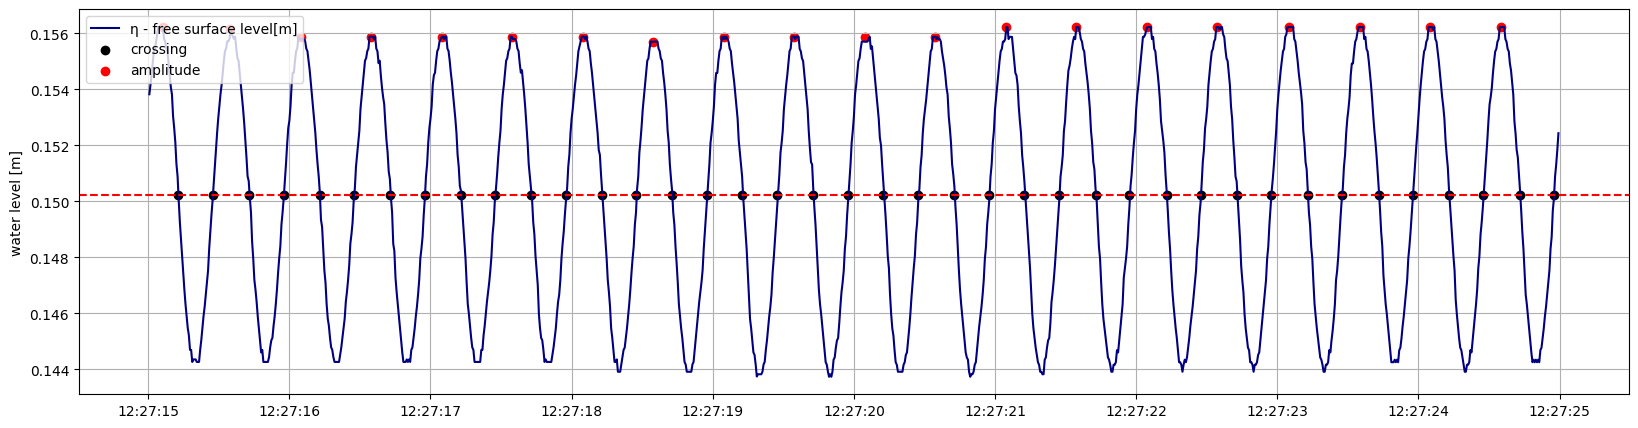

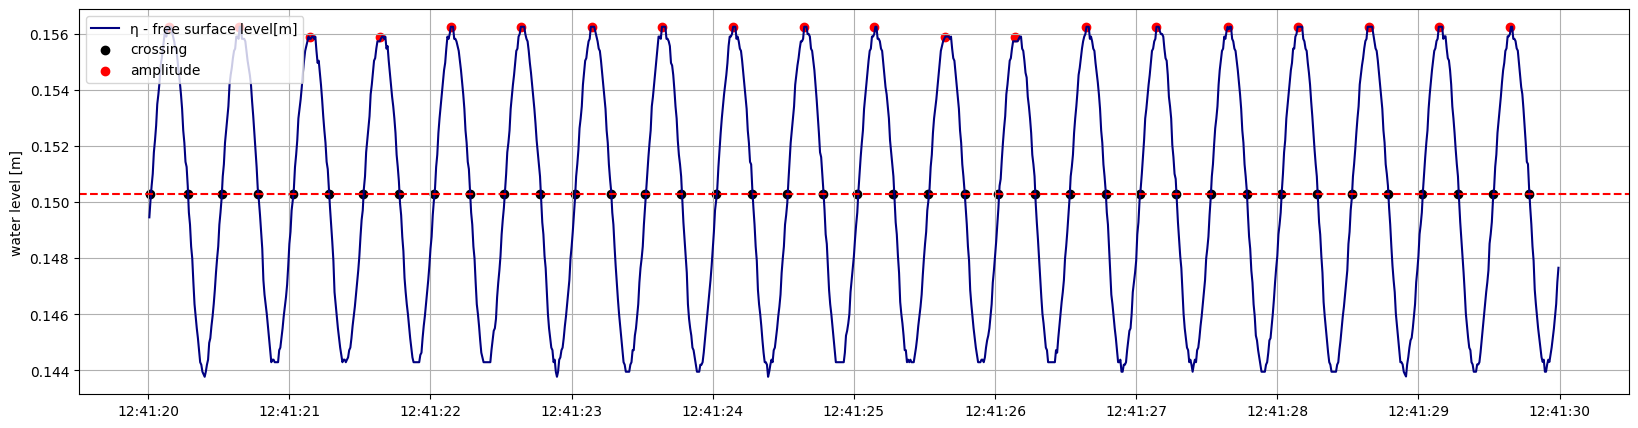

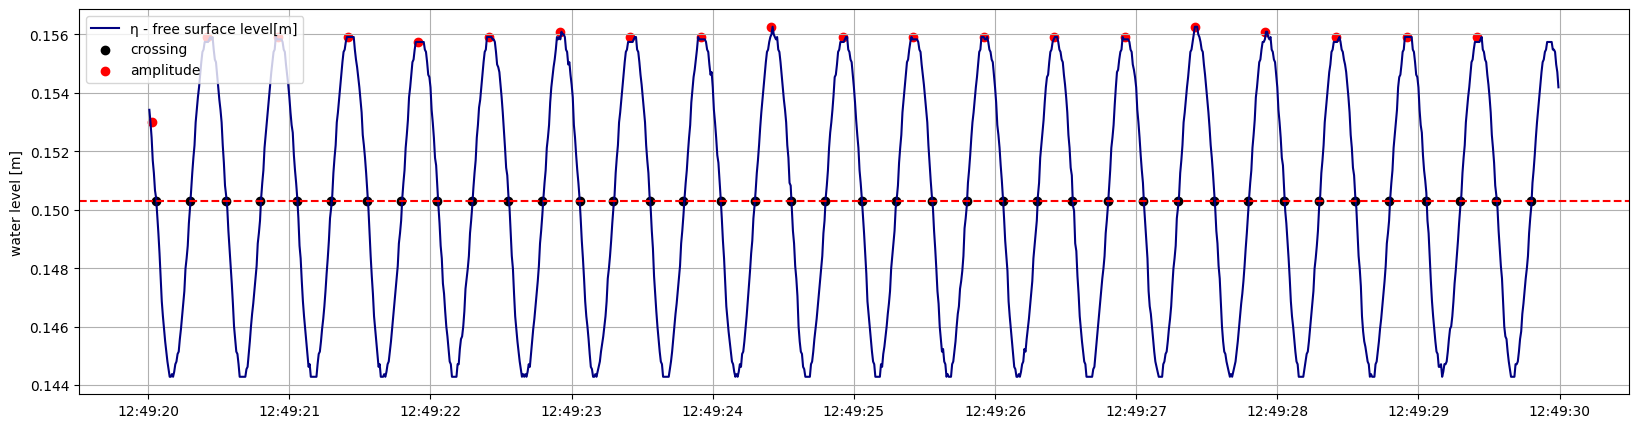

In [6]:
def plot_df(df, free_surface_level):
    subset_df = df
    crosing_points = subset_df[subset_df['crossing'] == True]
    crest_points = subset_df[subset_df['amplitude'].notna()]
    plt.figure(figsize=(20, 5))  # optional, to set the figure size
    plt.plot(subset_df['time'], subset_df['sensor4'], linestyle='-', color='navy', label = 'η - free surface level[m]')
    plt.scatter(crosing_points['time'],  [free_surface_level] * len(crosing_points), marker = 'o',  color='black', label='crossing')
    plt.scatter(crest_points['time'],  crest_points['amplitude'] + free_surface_level, marker = 'o',  color='red', label='amplitude')
    plt.grid(True) 
    plt.legend(loc='upper left')
    plt.ylabel('water level [m]')
    plt.axhline(y=free_surface_level, color='r', linestyle='--', label=f'y = free surface')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=1)) 
    plt.show()
for idx in range(0,3):
    plot_df(df_list[idx], free_sf[idx])

In [7]:
mean_amplitudes = np.empty(3)
std_amplitudes = np.empty(3)

for idx in range(0,3):
    df = df_list[idx]
    amplitudes_in_subset = df[df['amplitude'].notna()]
    #print(amplitudes_in_subset.amplitude.mean())
    mean_amplitudes[idx] = amplitudes_in_subset.amplitude.mean()
    std_amplitudes[idx] = amplitudes_in_subset.amplitude.std()


In [8]:
mean_amplitudes*1000, std_amplitudes*1000

(array([5.82072738, 5.90722178, 5.50829183]),
 array([0.18604682, 0.14363697, 0.67508498]))

In [9]:
def get_wave_number_from_linear_disp_relation(omega):
    g = 9.81
    return omega**2/g
    
# finding k (the wave number) from the non linear dispearsion relation
def get_wave_number_from_non_linear_disp_relation(a, omega):
    g = 9.81
    # Coefficients of the polynomial:
    coefficients = [g*a**2, 0, g, -omega**2]
    roots = np.roots(coefficients)
    positive = list(filter(lambda x: x.real > 0, roots))
    return positive[0].real

omega = 12.57
k_nonlinear_list = []
for a in mean_amplitudes:
    k_nonlinear = get_wave_number_from_non_linear_disp_relation(a, omega)
    print(a*k_nonlinear)
    k_nonlinear_list.append(k_nonlinear)
k_nonlinear_list               

0.09294860157638604
0.09430602626725139
0.08803704522098894


[15.968554353761451, 15.96453118244174, 15.98263996945506]